In [1]:
import warnings
warnings.filterwarnings(action='ignore')
import importlib
import transformer_type
from transformer_type.dataset import get_data
import torch
import pandas as pd

if torch.cuda.is_available(): device = torch.device ("cuda")
elif torch.backends.mps.is_available(): device = torch.device("mps")
else: device = torch.device('cpu')

from tqdm import tqdm

In [2]:
# params = [120, 1, 64, 300, 32, 512, 2, 1e-5, 0.1]
# 120-1_64_32-2_1e-05_100
# params = {'input_window' : [120],
#          'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [100],
#          'feature_size' : [64],
#          'd_ff' : [32],
#          'num_layers' : [2],
#          'lr' : [1e-5],
#          'device' : [device],
#          'dropout' : [0.1],
#          'is_save' : [True]}

# best loss
# params = {'input_window' : [120],
#           'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [100],
#          'feature_size' : [128],
#          'd_ff' : [512],
#          'num_layers' : [2],
#          'lr' : [1e-5],
#          'device' : [device],
#          'dropout' : [0.1],
#          'is_save' : [True]}

params = {'input_window' : [60],
          'pred_step' : [60],
         'batch_size' : [64],
         'epochs' : [100],
         'feature_size' : [128, 256],
         'd_ff' : [1024, 2048],
         'num_layers' : [4, 5],
         'lr' : [1e-5],
         'device' : [device],
         'dropout' : [0.1],
         'is_save' : [True],
         'diff' : [True],
         'mean_std' : [True],}



# params = {'input_window' : [60],
#           'pred_step' : [60],
#          'batch_size' : [64],
#          'epochs' : [10],
#          'feature_size' : [16],
#          'd_ff' : [16],
#          'num_layers' : [1],
#          'lr' : [1e-5],
#          'device' : [device],
#          'is_save' : [True],
#          'diff' : [True],
#          'mean_std' : [True]}

In [3]:
DATA_PATH = "../../data/kaggle_data/"

In [4]:
params['mean_std'][0]

True

In [5]:

# make dataset

def data_extract(df_dict, df, name, cols):
       for col in cols:
              df_dict[f"{name}_{col}"] = df.loc[df[col] != 0, col]
       return df_dict

train_data_list = []
val_data_list = []


# rom_df = pd.read_csv(DATA_PATH + "romania_elec_daily.csv")
# rom_cols = ['Consumption']
pmj_df = pd.read_csv(DATA_PATH + "pjm_elec_daily.csv")
pmj_cols = ['AEP', 'COMED', 'DAYTON', 'DEOK', 'DOM', 'DUQ', 'FE', 'NI', 'PJME', 'PJMW'] # 'PJM_Load', 'EKPC'
# pmj_cols = ['DUQ']

# ind_df = pd.read_csv(DATA_PATH + "india_elec_daily.csv")
# ind_cols = ['Punjab', 'Haryana', 'Rajasthan', 'Delhi', 'UP',
#        'Uttarakhand', 'HP', 'J&K', 'Chandigarh', 'Chhattisgarh', 'Gujarat',
#        'MP', 'Maharashtra', 'Goa', 'DNH', 'Andhra Pradesh', 'Telangana',
#        'Karnataka', 'Kerala', 'Tamil Nadu', 'Pondy', 'Bihar', 'Jharkhand',
#        'Odisha', 'West Bengal', 'Sikkim', 'Arunachal Pradesh', 'Assam',
#        'Manipur', 'Meghalaya', 'Mizoram', 'Nagaland', 'Tripura']
# mal_df = pd.read_csv(DATA_PATH + "malaysia_elec_daily.csv")
# mal_cols = ['load']
# tet_df = pd.read_csv(DATA_PATH + "tetouan_elec_daily.csv")
# tet_cols = ['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']
# steel_df = pd.read_csv(DATA_PATH + "steel_industry_elec_daily.csv")
# steel_cols = ['Usage_kWh']

df_dict = {}

# df_dict = data_extract(df_dict, rom_df, 'ROM', rom_cols)
df_dict = data_extract(df_dict, pmj_df, 'PMJ', pmj_cols)

# df_dict = data_extract(df_dict, mal_df, 'MAL', mal_cols)
# df_dict = data_extract(df_dict, ind_df, 'IND', ind_cols)
# df_dict = data_extract(df_dict, tet_df, 'TET', tet_cols)
# df_dict = data_extract(df_dict, steel_df, 'STEEL', steel_cols)

for df_name in df_dict:
    df = df_dict[df_name]
    train_data, val_data, scaler = get_data(df,
                                            params['input_window'][0],
                                            1,
                                            scaler_name='mm',
                                            diff=params['diff'][0],
                                            mean_std=params['mean_std'][0])
    train_data = train_data.to(device)
    val_data = val_data.to(device)
    print(df_name, len(train_data), len(val_data))
    train_data_list.append((train_data, df_name, scaler))
    val_data_list.append((val_data, df_name, scaler))
    break

PMJ_AEP 3983 950


In [6]:
new_train_data = []
split_idx = []
for i, val in enumerate(train_data[0][0]):
    if val == -100:
        split_idx.append(i)
print(split_idx)
for data in train_data:
    new_train_row = []

    for data_tmp in data:
        data_tmp = data_tmp.tolist()
        src = [0] + data_tmp[split_idx[1]+1:split_idx[2]]
        # mean = data[split_idx[0] + 1]
        # std = data[split_idx[1] + 1]
        tgt = data_tmp[split_idx[2]+1 + 1:]

        new_train_row.append([src, tgt])

    new_train_data.append(new_train_row)
new_train_data = torch.Tensor(new_train_data)

print(new_train_data.shape)

[1, 3, 63]
torch.Size([3983, 2, 2, 60])


In [7]:
from torch import nn
import math

In [8]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

In [12]:
import time, math
# from transformer_type.model import TransformerFull
from transformer_type.dataset import get_batch

calculate_loss_over_all_values = False

def train(model, train_data, type, epoch, optimizer, scheduler, criterion, batch_size, input_window, output_window, RESULT_TXT_PATH):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for batch, i in enumerate(range(0, len(train_data) - 1, batch_size)):
        data, targets = get_batch(train_data, i, batch_size, input_window + output_window)
        src, tgt = data
        src, tgt = src.reshape(-1, src.size(0), 1), tgt.reshape(-1, tgt.size(0), 1)

        targets = targets[0].reshape(targets[0].size(0), -1, 1)

        optimizer.zero_grad()
        output = model(src, tgt)

        if calculate_loss_over_all_values:
            loss = criterion(output, targets)
        else:
            loss = criterion(output[-output_window:], targets[-output_window:])
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if batch % log_interval == 0 and batch > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            with open(RESULT_TXT_PATH, 'a') as f:
                f.write('{} | epoch {:3d} | {:5d}/{:5d} batches | lr {:02.6f} | {:5.2f} ms | loss {:5.5f} | ppl {:8.2f}\n'.format(
                        type, epoch, batch, len(train_data) // batch_size, scheduler.get_lr()[0],
                        elapsed * 1000 / log_interval,
                        cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        
    return model, optimizer, scheduler, loss.item()



class TransformerFull(nn.Module):
    # Constructor
    def __init__( self, num_tokens=60, dim_model=256, num_heads=8, num_encoder_layers=3, num_decoder_layers=3, dropout_p=0.1, ):
        super().__init__()

        # INFO
        self.model_type = "Transformer"
        self.dim_model = dim_model

        # LAYERS
        self.positional_encoder = PositionalEncoding(d_model=dim_model)
        self.transformer = nn.Transformer(
            d_model=dim_model,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p,
        )
        self.out = nn.Linear(dim_model, num_tokens)

    def forward(self, src, tgt, tgt_mask=None, src_pad_mask=None, tgt_pad_mask=None):
        # Src, Tgt size 는 반드시 (batch_size, src sequence length) 여야 합니다.

        # Embedding + positional encoding - Out size = (batch_size, sequence length, dim_model)
        src = self.positional_encoder(src)
        tgt = self.positional_encoder(tgt)

        src = src.permute(1,0,2)
        tgt = tgt.permute(1,0,2)

        # Transformer blocks - Out size = (sequence length, batch_size, num_tokens)
        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)
        out = self.out(transformer_out)

        return out

    def get_tgt_mask(self, size) -> torch.tensor:
        mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
        mask = mask.float()
        mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
        mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

        return mask

    def create_pad_mask(self, matrix: torch.tensor, pad_token: int) -> torch.tensor:
        return (matrix == pad_token)
    

from torch import nn
model = TransformerFull()
train_data = train_data_list[0][0]
type = train_data_list[0][1]
epoch = 21
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)
criterion = nn.MSELoss()
batch_size = 64
input_window = 60
output_window = 1
RESULT_TXT_PATH = "transformer_results/full_test"

train(model=model,
      train_data=new_train_data,
      type=type,
      epoch=epoch,
      optimizer=optimizer,
      scheduler=scheduler,
      criterion=criterion,
      batch_size=batch_size,
      input_window=input_window,
      output_window=output_window,
      RESULT_TXT_PATH=RESULT_TXT_PATH)

(TransformerFull(
   (positional_encoder): PositionalEncoding()
   (transformer): Transformer(
     (encoder): TransformerEncoder(
       (layers): ModuleList(
         (0-2): 3 x TransformerEncoderLayer(
           (self_attn): MultiheadAttention(
             (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
           )
           (linear1): Linear(in_features=256, out_features=2048, bias=True)
           (dropout): Dropout(p=0.1, inplace=False)
           (linear2): Linear(in_features=2048, out_features=256, bias=True)
           (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
           (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
           (dropout1): Dropout(p=0.1, inplace=False)
           (dropout2): Dropout(p=0.1, inplace=False)
         )
       )
       (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
     )
     (decoder): TransformerDecoder(
       (layers): ModuleList(
         (0-2): 

In [ ]:
new_train_data.shape

torch.Size([3983, 2, 2, 61])

In [ ]:
# type_120-120_32_64-512-2_0.0005_200_0.1
# type_120-120_32_128-256-2_0.0005_200_0.1
# type_120-120_32_128-512-2_0.0005_200_0.1
# type_120-120_32_128-1024-2_0.0005_200_0.1

In [ ]:
# 120 60 64 128 512 3
# 120 60 64 128 1024 5

torch.autograd.set_detect_anomaly(True)
select_param(params, list(params.keys()))

NameError: name 'select_param' is not defined

In [ ]:
from transformer_type.model import TransAm

pred_seq = 60

model_param = (params['input_window'][0], params['feature_size'][0], params['num_layers'][0], params['d_ff'][0], params['dropout'][0])
MODEL_PATH = f"transformer_results/type_{model_param[0]}-60_64_{model_param[1]}-{model_param[3]}-{model_param[2]}_1e-05_100_{model_param[4]}_False_False"
models = {'PMJ_' + t : TransAm(*model_param[1:]) for t in pmj_cols}
for t in pmj_cols:
    models['PMJ_' + t].load_state_dict(torch.load(MODEL_PATH + f"/models/PMJ_{t}.pt"))
    models['PMJ_' + t].to(device)

In [ ]:
def inverse_scaling(value):
    return float(scaler.inverse_transform(value.cpu().detach().reshape(1, -1)))

In [15]:
cur_values = {}
predictions = {}
true_values = {}
input_window, output_window = 120, 1

predictions_period = {}
true_values_period = {}
cur_values_period = {}

for val_data, t, scaler in val_data_list[:]:
    model = model
    model.eval()
    cur_values[t] = []
    predictions[t] = []
    true_values[t] = []

    predictions_period[t] = []
    true_values_period[t] = []
    cur_values_period[t] = []

    # for i in tqdm(range(len(val_data) - pred_seq)):
    for i in tqdm(range(10)):
        data = val_data[i][0][:-1].reshape(-1, 1, 1)
        data.to(device)
        cur_values[t].append(float(scaler.inverse_transform(val_data[i][1][-1].cpu().detach().reshape(1, -1))))
        cur_values_period[t].append([float(scaler.inverse_transform(val_data[i][1][-1].cpu().detach().reshape(1, -1)))] * pred_seq)
        for _ in range(pred_seq):
            input = torch.clone(data[-input_window:])
            input[-output_window:] = 0     
            output = model(data[-input_window:])
            data = torch.cat((data[:-1], output[-1:], torch.Tensor([[[.0]]]).to(device)))
        predictions[t].append(float(scaler.inverse_transform(output[-1:].cpu().detach().reshape(1, -1))))
        true_values[t].append(float(scaler.inverse_transform(val_data[i + pred_seq][1][-1].cpu().detach().reshape(1, -1))))

        predictions_period[t].append([inverse_scaling(d) for d in list(data[-pred_seq-1:-1])])
        true_values_period[t].append([inverse_scaling(d) for d in list(val_data[i + pred_seq][1][-pred_seq-1:-1])])

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: forward() missing 1 required positional argument: 'tgt'

In [ ]:
for name in predictions_period:
    df = pd.DataFrame(predictions_period[name]).T
    df.to_csv(f"{MODEL_PATH}/{name}_{pred_seq}.csv")

tensor(0.1333)
tensor(0.1464)
tensor(0.1646)
tensor(0.1084)
tensor(0.0788)
tensor(0.1063)
tensor(0.0893)
tensor(0.0676)
tensor(0.1076)
tensor(0.0751)


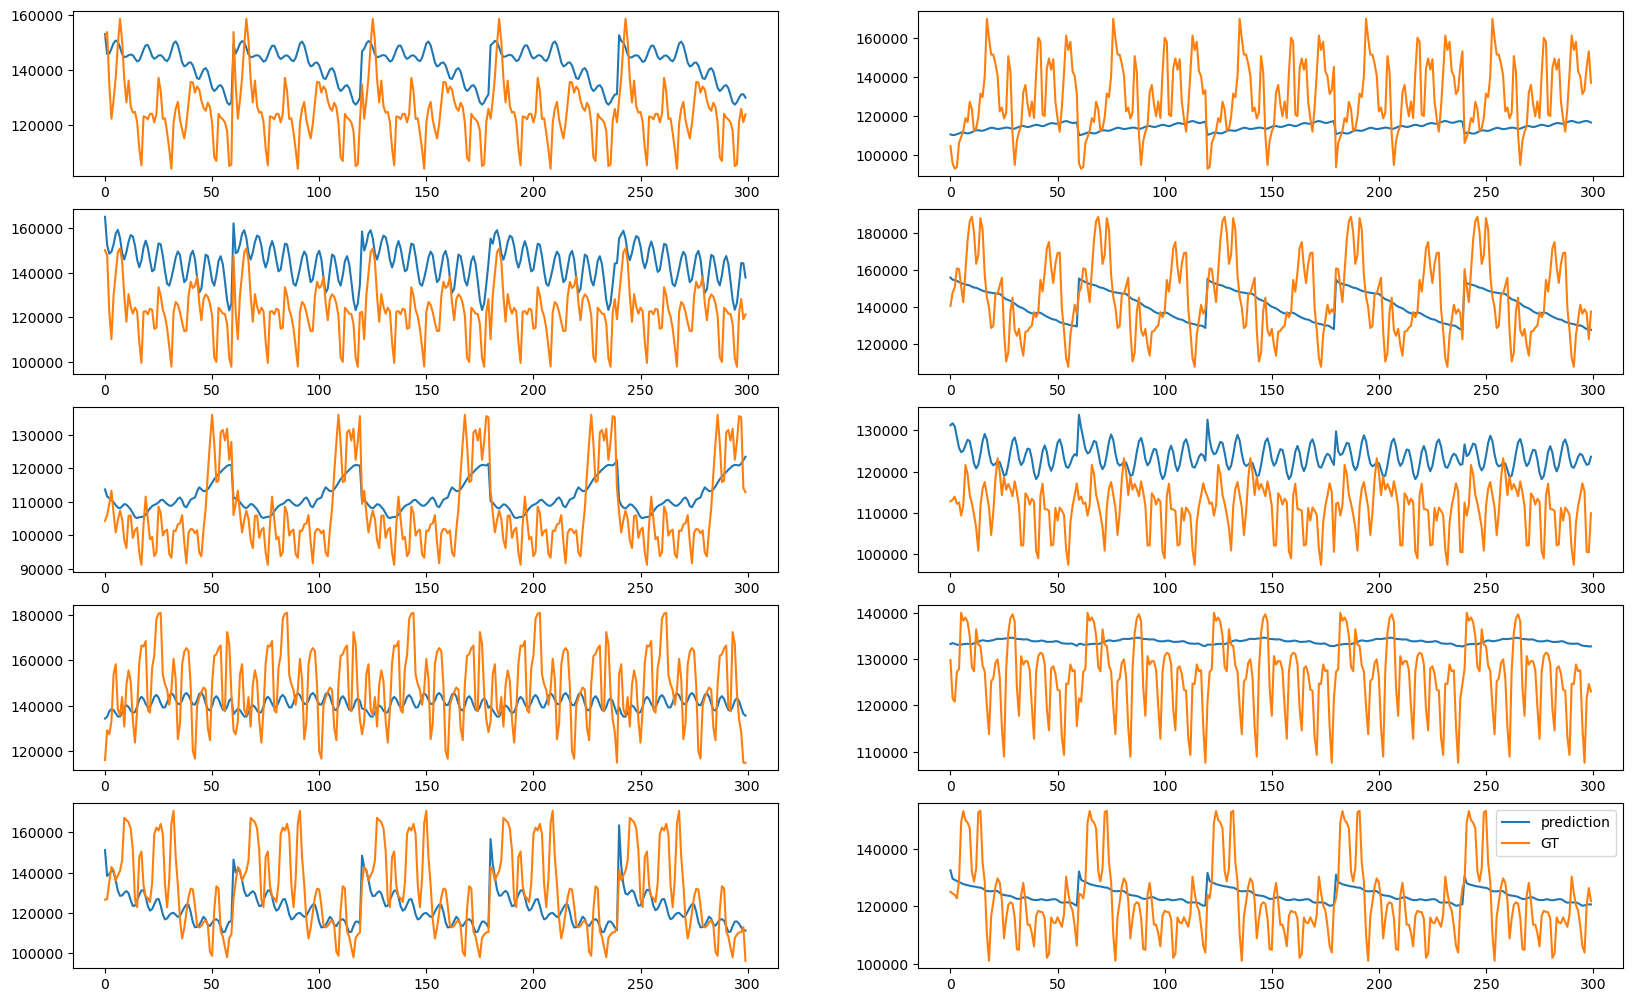

In [ ]:
from torchmetrics.regression import SymmetricMeanAbsolutePercentageError as SMAPE, MeanAbsolutePercentageError as MAPE, R2Score as R2
import matplotlib.pyplot as plt

# tensor(0.0757)
# tensor(0.1433)
# tensor(0.2411)
# tensor(0.1079)
# tensor(0.2570)
# tensor(0.1562)
# tensor(0.1002)
# tensor(0.2347)
# tensor(0.1141)
# tensor(0.2481)

smape = SMAPE()
idx = 0
sub_num = 1
plt.figure(figsize=(20, 15 * len(predictions_period) // len(val_data_list)))
for t in predictions_period:
    pred, true_val = [], []
    for p, gt in zip(predictions_period[t][idx : idx + 5], true_values_period[t][idx : idx + 5]):
        pred += p[:]
        true_val += gt[:]
    plt.subplot(len(predictions_period) // 2 + 1, 2, sub_num)
    plt.rc('font', size=10)
    plt.plot(pred, label='prediction')
    plt.plot(true_val, label="GT")
    print(smape(torch.tensor(pred), torch.tensor(true_val)))

    sub_num += 1

plt.legend()
plt.show()